**Background:**

As a talent sourcing and management company, we are interested in finding talented individuals for sourcing these candidates to technology companies. Finding talented candidates is not easy, for several reasons. The first reason is one needs to understand what the role is very well to fill in that spot, this requires understanding the client’s needs and what they are looking for in a potential candidate. The second reason is one needs to understand what makes a candidate shine for the role we are in search for. Third, where to find talented individuals is another challenge.

The nature of our job requires a lot of human labor and is full of manual operations. Towards automating this process we want to build a better approach that could save us time and finally help us spot potential candidates that could fit the roles we are in search for. Moreover, going beyond that for a specific role we want to fill in we are interested in developing a machine learning powered pipeline that could spot talented individuals, and rank them based on their fitness.

We are right now semi-automatically sourcing a few candidates, therefore the sourcing part is not a concern at this time but we expect to first determine best matching candidates based on how fit these candidates are for a given role. We generally make these searches based on some keywords such as “full-stack software engineer”, “engineering manager” or “aspiring human resources” based on the role we are trying to fill in. These keywords might change, and you can expect that specific keywords will be provided to you.

Assuming that we were able to list and rank fitting candidates, we then employ a review procedure, as each candidate needs to be reviewed and then determined how good a fit they are through manual inspection. This procedure is done manually and at the end of this manual review, we might choose not the first fitting candidate in the list but maybe the 7th candidate in the list. If that happens, we are interested in being able to re-rank the previous list based on this information. This supervisory signal is going to be supplied by starring the 7th candidate in the list. Starring one candidate actually sets this candidate as an ideal candidate for the given role. Then, we expect the list to be re-ranked each time a candidate is starred.

**Data Description:**

The data comes from our sourcing efforts. We removed any field that could directly reveal personal details and gave a unique identifier for each candidate.

Attributes:

    id : unique identifier for candidate (numeric)
    job_title : job title for candidate (text)
    location : geographical location for candidate (text)
    connections: number of connections candidate has, 500+ means over 500 (text)

Output (desired target):
    fit - how fit the candidate is for the role? (numeric, probability between 0-1)

**Keywords:** “Aspiring human resources” or “seeking human resources”

**Goal(s):**

    Predict how fit the candidate is based on their available information (variable fit)

**Success Metric(s):**

    Rank candidates based on a fitness score.
    Re-rank candidates when a candidate is starred.

**Bonus(es):**

We are interested in a robust algorithm, tell us how your solution works and show us how your ranking gets better with starring action.

How can we filter out candidates which in the first place should not be in this list?

Can we determine a cut-off point that would work for other roles without losing high potential candidates?


In [1]:
# business objective to find human resourse professional that have the knowledge to find good candidates for technical roles

In [2]:
# matching the keyword that with profile that HR is looking for ('aspiring human resources',“seeking human resources”)

In [76]:
import pandas as pd
import numpy as np
import nltk
import string
from sklearn.preprocessing import StandardScaler
# Uncomment the following line the first time you run the code
# nltk.download('stopwords')
# nltk.download('wordnet')

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.spatial.distance import cosine
from sentence_transformers import SentenceTransformer, util
import tensorflow as tf
from sklearn.model_selection import train_test_split

import tensorflow as tf

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

from IPython.display import display
import matplotlib.pyplot as plt
from wordcloud import WordCloud

%matplotlib inline

In [5]:
import pandas as pd
import numpy as np
import os
import random
from itertools import combinations

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.spatial.distance import cosine
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split

import tensorflow as tf

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

from IPython.display import display
import matplotlib.pyplot as plt
from wordcloud import WordCloud

Read in raw data

In [6]:
df1 = pd.read_csv(r'C:\Users\dgarb\OneDrive\Documents\APZIVA\Project3\data\potential-talentsAspiringhumanresourcesseekinghumanresources.csv')

In [7]:
df1.shape

(104, 5)

In [8]:
# Reccommendation
# 1 do keyword mapping with a similarity score
# 

In [9]:
# display all 104 rows
pd.set_option('display.max_rows',None)

#specify no max value for the column width
pd.set_option('display.max_colwidth', None)

# pd.reset_option('max_columns')
# pd.set_option('max_columns',104)
df1.head(104)

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Program in Korea),Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN
6,7,Student at Humber College and Aspiring Human Resources Generalist,Kanada,61,NaN
7,8,HR Senior Specialist,San Francisco Bay Area,500+,NaN
8,9,Student at Humber College and Aspiring Human Resources Generalist,Kanada,61,NaN
9,10,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,NaN


### Convert to lower case

In [10]:
df1['job_title'] = df1['job_title'].str.lower()

df1['location'] = df1['location'].str.lower()

### Remove STOP words 

In [11]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [12]:
df1['job_title'] = df1['job_title'].map(lambda text: ' '.join([word for word in text.split() if word not in stop ]))

In [13]:
df1['job_title'].head()

0    2019 c.t. bauer college business graduate (magna cum laude) aspiring human resources professional
1                                                  native english teacher epik (english program korea)
2                                                                aspiring human resources professional
3                                                                  people development coordinator ryan
4                                                         advisory board member celal bayar university
Name: job_title, dtype: object

In [14]:
df1.head()

,id,job_title,location,connection,fit
0,1,2019 c.t. bauer college business graduate (magna cum laude) aspiring human resources professional,"houston, texas",85,NaN
1,2,native english teacher epik (english program korea),kanada,500+,NaN
2,3,aspiring human resources professional,"raleigh-durham, north carolina area",44,NaN
3,4,people development coordinator ryan,"denton, texas",500+,NaN
4,5,advisory board member celal bayar university,"i̇zmir, türkiye",500+,NaN


### Remove special characters 

In [15]:
test_string = 'native english teacher epik (english program korea)'

In [16]:
# from textblob import TextBlob

In [17]:
# txt_toks = TextBlob(test_string).words
# txt_toks
# ' '.join(txt_toks)


In [18]:
# from textblob import TextBlob

# def remove_special_char(string):
#     txt_tokens = TextBlob(string).words
#     clean_txt_tokens = [word for word in txt_tokens if word.isalnum()]
#     return ' '.join(clean_txt_tokens)

In [19]:
def remove_special_characters_keep_spaces(input_string):
    # Initialize an empty string to store the result
    result_string = ""

    # Iterate through each character in the input string
    for char in input_string:
        # Check if the character is alphanumeric or a space
        if char.isalnum() or char.isspace():
            # If alphanumeric or space, add it to the result string
            result_string += char
    
    # Replace consecutive spaces with a single space
    result_string = ' '.join(result_string.split())

    return result_string

In [20]:
# test function

remove_special_characters_keep_spaces(test_string)

'native english teacher epik english program korea'

**word.isalnum()** is a string method in Python used to check if all characters in a given string are alphanumeric, meaning they are either letters (alphabetic characters) or numbers (digits).

If word is a string, word.isalnum() returns True if all characters in the string are either letters or digits, and False otherwise.
Spaces, punctuation, or any special characters other than letters and digits will cause word.isalnum() to return False.

In [21]:
# df['selftext'] = df['selftext'].apply(lambda text: " ".join(word for word in text.split() if word not in stop))

df1['job_title'] = df1['job_title'].map(remove_special_characters_keep_spaces)

In [22]:
df1['job_title'].head()

0    2019 ct bauer college business graduate magna cum laude aspiring human resources professional
1                                                native english teacher epik english program korea
2                                                            aspiring human resources professional
3                                                              people development coordinator ryan
4                                                     advisory board member celal bayar university
Name: job_title, dtype: object

In [23]:
df1['location'] = df1['location'].map(remove_special_characters_keep_spaces)

In [24]:
df1['connection'] = df1['connection'].map(remove_special_characters_keep_spaces)
df1['connection'].head()

0     85
1    500
2     44
3    500
4    500
Name: connection, dtype: object

In [25]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB


### Tokenize and lemmitize job_title

In [26]:
from nltk.stem.wordnet import WordNetLemmatizer 
lem = WordNetLemmatizer()

In [27]:
test_string = 'native english teacher epik (english program korea)'
new_test_string = remove_special_characters_keep_spaces(test_string)
new_test_string

'native english teacher epik english program korea'

In [28]:
# new_test_string_lst = new_test_string.split()
# new_test_string_lst
# lemmatized_list  = [lem.lemmatize(word) for word in new_test_string_lst]
# lemmatized_list

In [29]:
# ' '.join(lemmatized_list)

The code below tokenizes and lemmatizes each string in job_title

In [30]:

df1['job_title'] = df1['job_title'].apply(lambda text: ' '.join([lem.lemmatize(word) for word in text.split()]))

### Convert connection to integer

In [31]:
df1['connection'].astype(int).dtype

dtype('int32')

In [32]:
df1['connection'] = df1['connection'].astype(int)

In [33]:
df1.dtypes

id              int64
job_title      object
location       object
connection      int32
fit           float64
dtype: object

In [34]:
df1.sample(5)

,id,job_title,location,connection,fit
89,90,undergraduate research assistant styczynski lab,greater atlanta area,155,NaN
10,11,student chapman university,lake forest california,2,NaN
25,26,hr senior specialist,san francisco bay area,500,NaN
49,50,student humber college aspiring human resource generalist,kanada,61,NaN
58,59,people development coordinator ryan,denton texas,500,NaN


In [35]:
# import sys
# !{sys.executable} -m pip install autocorrect
# correctly installed

In [36]:
# from autocorrect import Speller
# spell = Speller(lang='en')
# print(spell('Kanada'))

### **clean up location column**

    america bibleşik devletleri is the turkish spelling of the united states
    
    türkiye is the turkish spelling of the country turkey
    
    kanada is the turkish spelling of canada




In [37]:
df1['location'] = df1['location'].str.replace('amerika birleşik devletleri','united states' )

df1['location'] = df1['location'].str.replace('türkiye','turkey')

df1['location'] = df1['location'].str.replace('kanada','canada') 

In [38]:
df1['location'].sample(20)

102             greater los angeles area
90                  greater chicago area
66              jackson mississippi area
41                    houston texas area
8                                 canada
77                         united states
80            chattanooga tennessee area
43                         houston texas
87                   milpitas california
94             bridgewater massachusetts
16     raleighdurham north carolina area
85                 gaithersburg maryland
83                   highland california
70     raleighdurham north carolina area
95                     lafayette indiana
28                    houston texas area
14                         houston texas
74                   san jose california
92                 long beach california
37                san francisco bay area
Name: location, dtype: object

#### installed transformers

In [39]:
# !pip install sentence_transformers 
# stop running

sentence_transformers installed

In [40]:
# from nltk.stem.porter import PorterStemmer 
# stem = PorterStemmer()

# from nltk.stem.wordnet import WordNetLemmatizer 
# lem = WordNetLemmatizer()

# lem.lemmatize('feet')

# text = 'aspiring human resources professional'

# ' '.join([lem.lemmatize(word) for word in text.split()])

In [41]:
# df1['job_title'] = df1['job_title'].apply(lambda text: ' '.join([lem.lemmatize(word) for word in text.split()]))
# df1['job_title'] = 

In [42]:
df1.shape

(104, 5)

In [43]:
# df1['location'].value_counts()

In [44]:
def proc_freq(df,variable_):  #Note variable_ must be given in quotes; example variable_: 'xyz'
    datax = df[variable_].value_counts().sort_index()
    
    datay = pd.DataFrame({
        variable_: datax.index,
        'Frequency': datax.values,
        'Percent': ((datax.values/datax.values.sum())*100).round(1),
        'Cumulative Frequency': datax.values.cumsum(),
        'Cumulative Percent': ((datax.values.cumsum()/datax.values.sum())*100).round(1)   })
    
    #datay.set_index(variable_)
    
    return(datay)

In [45]:
df1['location'].value_counts()

canada                                12
raleighdurham north carolina area      8
houston texas area                     8
greater new york city area             7
houston texas                          7
denton texas                           6
san francisco bay area                 5
greater philadelphia area              5
izmir turkey                           4
lake forest california                 4
atlanta georgia                        4
chicago illinois                       2
austin texas area                      2
greater atlanta area                   2
united states                          2
long beach california                  1
milpitas california                    1
greater chicago area                   1
torrance california                    1
greater los angeles area               1
bridgewater massachusetts              1
lafayette indiana                      1
kokomo indiana area                    1
las vegas nevada area                  1
cape girardeau m

In [46]:
df_test = df1[['job_title']].sample(5)
df_test

,job_title
99,aspiring human resource manager graduating may 2020 seeking entrylevel human resource position st louis
9,seeking human resource hris generalist position
4,advisory board member celal bayar university
29,seeking human resource opportunity
12,human resource coordinator intercontinental buckhead atlanta


### create word frequency for job_title

In [47]:
dict_job ={}
for row in  df1['job_title']:
    lst = row.split()
    for word in lst:
        dict_job[word] = dict_job.get(word,0) +1

In [48]:
dict_job_list= list(dict_job.items())
sorted(dict_job_list,key = lambda x: x[1],reverse=True)

[('human', 63),
 ('resource', 63),
 ('aspiring', 35),
 ('professional', 21),
 ('student', 16),
 ('seeking', 15),
 ('college', 14),
 ('generalist', 14),
 ('university', 12),
 ('specialist', 12),
 ('business', 11),
 ('english', 10),
 ('coordinator', 10),
 ('2019', 7),
 ('ct', 7),
 ('bauer', 7),
 ('graduate', 7),
 ('magna', 7),
 ('cum', 7),
 ('laude', 7),
 ('humber', 7),
 ('position', 7),
 ('manager', 7),
 ('people', 6),
 ('development', 6),
 ('ryan', 6),
 ('hr', 6),
 ('senior', 6),
 ('management', 6),
 ('native', 5),
 ('teacher', 5),
 ('epik', 5),
 ('program', 5),
 ('korea', 5),
 ('advisory', 4),
 ('board', 4),
 ('member', 4),
 ('celal', 4),
 ('bayar', 4),
 ('hris', 4),
 ('chapman', 4),
 ('svp', 4),
 ('chro', 4),
 ('marketing', 4),
 ('communication', 4),
 ('csr', 4),
 ('officer', 4),
 ('engie', 4),
 ('houston', 4),
 ('woodland', 4),
 ('energy', 4),
 ('gphr', 4),
 ('sphr', 4),
 ('intercontinental', 4),
 ('buckhead', 4),
 ('atlanta', 4),
 ('opportunity', 4),
 ('internship', 3),
 ('director

In [49]:
# collaborative filtering  csr most likely = corporate social responsibility as opposed to customer service representitive
# content-based filtering

###  fix acronyms in job_title and create job_title2 using a lookup dictionary

In [50]:
lookup_dict = {'hr': 'human resources','chro':'chief human resources officer','epik':'english teacher korea',
               'hris':'human resources information system','svp':'senior vice president',
               'chro':'chief human resources officer','csr':'corporate social responsibility',
               'gphr':'global professional human resources','sphr':'senior professional human resources',
              'mes':'manufacturering execution systems','gis':'geographic information system','rrp':'recommended retail price',
              }

### use list comprehension to look up words in lookup_dict 

### use join to convert the resulting list into a string

In [51]:
text = 'svp chro marketing communications csr officer engie houston woodlands energy gphr sphr'
lst = text.split()
edited_text_list = [lookup_dict[word] if word in lookup_dict else word for word in lst]
' '.join(edited_text_list)

'senior vice president chief human resources officer marketing communications corporate social responsibility officer engie houston woodlands energy global professional human resources senior professional human resources'

### create fix_acronyms function so that each line of text can be corrected using  lookup_dict

In [52]:
def fix_acronyms(text):
    lst = text.split()
    edited_text_list = [lookup_dict[word] if word in lookup_dict else word for word in lst]
    return ' '.join(edited_text_list)    

In [53]:
text = 'svp chro marketing communications csr officer engie houston woodlands energy gphr sphr'

fix_acronyms(text)

'senior vice president chief human resources officer marketing communications corporate social responsibility officer engie houston woodlands energy global professional human resources senior professional human resources'

### apply fuction to df1.job_title2

In [54]:
df1['job_title2'] = df1['job_title'].apply(fix_acronyms)
df1.sample(5)
   

,id,job_title,location,connection,fit,job_title2
65,66,experienced retail manager aspiring human resource professional,austin texas area,57,NaN,experienced retail manager aspiring human resource professional
7,8,hr senior specialist,san francisco bay area,500,NaN,human resources senior specialist
75,76,aspiring human resource professional passionate helping create inclusive engaging work environment,new york new york,212,NaN,aspiring human resource professional passionate helping create inclusive engaging work environment
20,21,aspiring human resource professional,raleighdurham north carolina area,44,NaN,aspiring human resource professional
93,94,seeking human resource opportunity open travel relocation,united states,415,NaN,seeking human resource opportunity open travel relocation


### create word frequency for job_title2

dict_job ={}
for row in  df1['job_title2']:
    lst = row.split()
    for word in lst:
        dict_job[word] = dict_job.get(word,0) +1

dict_job_list= list(dict_job.items())
sorted(dict_job_list,key = lambda x: x[1],reverse=True)


## create wordcloud

In [55]:
wc = WordCloud(background_color="white", max_words=2000, width=800, height=400)
# generate word cloud
wc.generate(' '.join(df1['job_title2']))

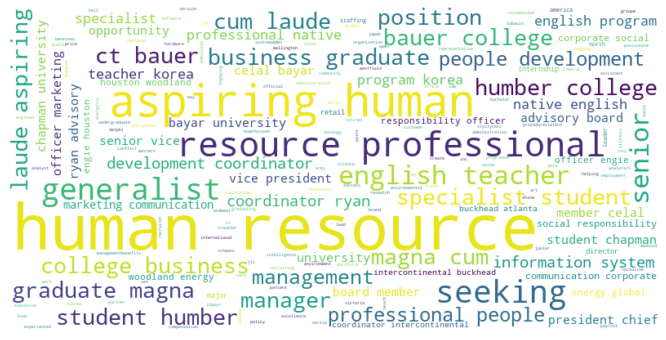

In [56]:
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## split and lemmatize (needs to be done again because of acronyms)

In [57]:
df1['job_title2_lst'] = df1['job_title2'].apply(lambda text: [lem.lemmatize(word) for word in text.split()])
df1 = df1.drop(columns = ['job_title2_lst'])

In [58]:
df1.shape

(104, 6)

In [59]:
df1.sample(10)

,id,job_title,location,connection,fit,job_title2
84,85,rrp brand portfolio executive jti japan tobacco international,greater philadelphia area,500,NaN,recommended retail price brand portfolio executive jti japan tobacco international
75,76,aspiring human resource professional passionate helping create inclusive engaging work environment,new york new york,212,NaN,aspiring human resource professional passionate helping create inclusive engaging work environment
37,38,hr senior specialist,san francisco bay area,500,NaN,human resources senior specialist
24,25,student humber college aspiring human resource generalist,canada,61,NaN,student humber college aspiring human resource generalist
41,42,svp chro marketing communication csr officer engie houston woodland energy gphr sphr,houston texas area,500,NaN,senior vice president chief human resources officer marketing communication corporate social responsibility officer engie houston woodland energy global professional human resources senior professional human resources
39,40,seeking human resource hris generalist position,greater philadelphia area,500,NaN,seeking human resource human resources information system generalist position
91,92,seeking employment opportunity within customer service patient care,torrance california,64,NaN,seeking employment opportunity within customer service patient care
30,31,2019 ct bauer college business graduate magna cum laude aspiring human resource professional,houston texas,85,NaN,2019 ct bauer college business graduate magna cum laude aspiring human resource professional
86,87,bachelor science biology victoria university wellington,baltimore maryland,40,NaN,bachelor science biology victoria university wellington
66,67,human resource staffing recruiting professional,jackson mississippi area,500,NaN,human resource staffing recruiting professional


## split and lemmatize keywords

In [60]:
keywords = ['aspiring human resources' , 'seeking human resources']
keywords_split = list(map(lambda text: [lem.lemmatize(word) for word in text.split()], keywords))
keywords_split

[['aspiring', 'human', 'resource'], ['seeking', 'human', 'resource']]

In [61]:
phrase_one = ' '.join(keywords_split[0])
phrase_one

'aspiring human resource'

In [62]:
phrase_two = ' '.join(keywords_split[1])
phrase_two

'seeking human resource'

In [63]:
print('phrase_one: ',phrase_one)
print(' ')
print('phrase_two: ',phrase_two)

phrase_one:  aspiring human resource
 
phrase_two:  seeking human resource


# Vectorizing with BERT and caclulating cosine similarity


In [64]:
def check_similarity(column_name, embeddings, X_search):
    copy_df = df1.copy()

    score_list = []
    for i in range(len(df1)):
        score_list.append(1 - cosine(embeddings[i], X_search))
    
    copy_df[column_name] = score_list
    display(copy_df.sort_values(by = column_name, ascending=False, ignore_index=True).head(10))
    return score_list

## BERT Model

In [65]:
# BERT Model
# col_one_list = df1['one'].tolist()

s_embedder = SentenceTransformer('all-mpnet-base-v2')
# s_embedder = SentenceTransformer('bert-base-nli-mean-tokens')
bert_embeddings = s_embedder.encode(df1.job_title2)
print(type(bert_embeddings))
print('bert_embeddings.shape: ',bert_embeddings.shape)
# print(bert_embeddings)
print(' ')
X_search_one = s_embedder.encode(phrase_one)
X_search_two = s_embedder.encode(phrase_two)
print('X_search_one type: ',type(X_search_one))
print('X_search_one.shape: ',X_search_one.shape)

print('X_search_two type: ',type(X_search_two))
print('X_search_two.shape: ',X_search_two.shape)

<class 'numpy.ndarray'>
bert_embeddings.shape:  (104, 768)
 
X_search_one type:  <class 'numpy.ndarray'>
X_search_one.shape:  (768,)
X_search_two type:  <class 'numpy.ndarray'>
X_search_two.shape:  (768,)


## Check Cosine Similarity

In [69]:
print("Top 10 candidates for the job title:", phrase_one)
bert_similarity_query1 = check_similarity("BERT_cosine_sim_query1", bert_embeddings, X_search_one)

print("Top 10 candidates for the job title:", phrase_two)
bert_similarity_query2 = check_similarity("BERT_cosine_sim_query2", bert_embeddings, X_search_two)

df1['bert_similarity_query1'] = bert_similarity_query1

df1['bert_similarity_query2'] = bert_similarity_query2

# check_similarity('BERT_cos_similaarity_one',bert_embeddings,X_search_one,top_n = 10)

Top 10 candidates for the job title: aspiring human resource


,id,job_title,location,connection,fit,job_title2,BERT_cosine_sim_query1
0,17,aspiring human resource professional,raleighdurham north carolina area,44,NaN,aspiring human resource professional,0.880906
1,3,aspiring human resource professional,raleighdurham north carolina area,44,NaN,aspiring human resource professional,0.880906
2,58,aspiring human resource professional,raleighdurham north carolina area,44,NaN,aspiring human resource professional,0.880906
3,33,aspiring human resource professional,raleighdurham north carolina area,44,NaN,aspiring human resource professional,0.880906
4,46,aspiring human resource professional,raleighdurham north carolina area,44,NaN,aspiring human resource professional,0.880906
5,97,aspiring human resource professional,kokomo indiana area,71,NaN,aspiring human resource professional,0.880906
6,21,aspiring human resource professional,raleighdurham north carolina area,44,NaN,aspiring human resource professional,0.880906
7,6,aspiring human resource specialist,greater new york city area,1,NaN,aspiring human resource specialist,0.877840
8,49,aspiring human resource specialist,greater new york city area,1,NaN,aspiring human resource specialist,0.877840
9,24,aspiring human resource specialist,greater new york city area,1,NaN,aspiring human resource specialist,0.877840


Top 10 candidates for the job title: seeking human resource


,id,job_title,location,connection,fit,job_title2,BERT_cosine_sim_query2
0,30,seeking human resource opportunity,chicago illinois,390,NaN,seeking human resource opportunity,0.881616
1,28,seeking human resource opportunity,chicago illinois,390,NaN,seeking human resource opportunity,0.881616
2,99,seeking human resource position,las vegas nevada area,48,NaN,seeking human resource position,0.838536
3,67,human resource staffing recruiting professional,jackson mississippi area,500,NaN,human resource staffing recruiting professional,0.810194
4,60,aspiring human resource specialist,greater new york city area,1,NaN,aspiring human resource specialist,0.728420
5,49,aspiring human resource specialist,greater new york city area,1,NaN,aspiring human resource specialist,0.728420
6,24,aspiring human resource specialist,greater new york city area,1,NaN,aspiring human resource specialist,0.728420
7,36,aspiring human resource specialist,greater new york city area,1,NaN,aspiring human resource specialist,0.728420
8,6,aspiring human resource specialist,greater new york city area,1,NaN,aspiring human resource specialist,0.728420
9,74,human resource professional,greater boston area,16,NaN,human resource professional,0.705744


In [70]:
df1.columns

Index(['id', 'job_title', 'location', 'connection', 'fit', 'job_title2',
       'bert_similarity_query1', 'bert_similarity_query2'],
      dtype='object')

## Standardize 

In [87]:
df2 = df1[['connection','bert_similarity_query1','bert_similarity_query2']]
df2.head()

,connection,bert_similarity_query1,bert_similarity_query2
0,85,0.736274,0.573587
1,500,0.327389,0.296891
2,44,0.880906,0.672487
3,500,0.529167,0.505585
4,500,0.356170,0.298487


In [90]:
ss = StandardScaler()
features = list(df2.columns)

df2_standardized = pd.DataFrame(ss.fit_transform(df2), columns = features)

print(df2_standardized.shape)
df2_standardized.describe()

(104, 3)


,connection,bert_similarity_query1,bert_similarity_query2
count,1.040000e+02,1.040000e+02,1.040000e+02
mean,-6.405133e-17,-1.900189e-16,-7.686159e-17
std,1.004843e+00,1.004843e+00,1.004843e+00
min,-1.181165e+00,-2.397867e+00,-3.054711e+00
25%,-9.735180e-01,-9.189655e-01,-4.530442e-01
50%,-3.144651e-01,1.195111e-01,2.280268e-01
75%,1.071352e+00,6.876640e-01,7.629803e-01
max,1.071352e+00,1.601368e+00,1.922775e+00


In [92]:
df2_standardized.columns = ['std_connection', 'std_bert_similarity_query1', 'std_bert_similarity_query2']

In [93]:
df2_standardized.describe()

,std_connection,std_bert_similarity_query1,std_bert_similarity_query2
count,1.040000e+02,1.040000e+02,1.040000e+02
mean,-6.405133e-17,-1.900189e-16,-7.686159e-17
std,1.004843e+00,1.004843e+00,1.004843e+00
min,-1.181165e+00,-2.397867e+00,-3.054711e+00
25%,-9.735180e-01,-9.189655e-01,-4.530442e-01
50%,-3.144651e-01,1.195111e-01,2.280268e-01
75%,1.071352e+00,6.876640e-01,7.629803e-01
max,1.071352e+00,1.601368e+00,1.922775e+00


## Add standardized connection to each column of cosine similarities

In [98]:
df2_standardized['sum_query1'] = df2_standardized.std_connection + df2_standardized.std_bert_similarity_query1

df2_standardized['sum_query2'] = df2_standardized.std_connection + df2_standardized.std_bert_similarity_query2

## concatenate (join) df1 and df2_standardized

In [107]:
df3 = pd.concat([df1, df2_standardized], axis = 1, sort=False).head(10)
print(df3.shape)
df3.head()

(10, 13)


,id,job_title,location,connection,fit,job_title2,bert_similarity_query1,bert_similarity_query2,std_connection,std_bert_similarity_query1,std_bert_similarity_query2,sum_query1,sum_query2
0,1,2019 ct bauer college business graduate magna cum laude aspiring human resource professional,houston texas,85,NaN,2019 ct bauer college business graduate magna cum laude aspiring human resource professional,0.736274,0.573587,-0.801984,0.865150,0.228027,0.063166,-0.573957
1,2,native english teacher epik english program korea,canada,500,NaN,native english teacher english teacher korea english program korea,0.327389,0.296891,1.071352,-1.216201,-1.294335,-0.144850,-0.222983
2,3,aspiring human resource professional,raleighdurham north carolina area,44,NaN,aspiring human resource professional,0.880906,0.672487,-0.987060,1.601368,0.772166,0.614308,-0.214894
3,4,people development coordinator ryan,denton texas,500,NaN,people development coordinator ryan,0.529167,0.505585,1.071352,-0.189091,-0.146118,0.882261,0.925233
4,5,advisory board member celal bayar university,izmir turkey,500,NaN,advisory board member celal bayar university,0.356170,0.298487,1.071352,-1.069699,-1.285552,0.001653,-0.214201


## Sort

**sort by sum_query1**

In [106]:
df3.sort_values('sum_query1',ascending=False).head(10)


,id,job_title,location,connection,fit,job_title2,bert_similarity_query1,bert_similarity_query2,std_connection,std_bert_similarity_query1,std_bert_similarity_query2,sum_query1,sum_query2
66,67,human resource staffing recruiting professional,jackson mississippi area,500,NaN,human resource staffing recruiting professional,0.717234,0.810194,1.071352,0.768229,1.529814,1.839581,2.601166
50,51,hr senior specialist,san francisco bay area,500,NaN,human resources senior specialist,0.672621,0.670818,1.071352,0.541137,0.762980,1.612489,1.834332
60,61,hr senior specialist,san francisco bay area,500,NaN,human resources senior specialist,0.672621,0.670818,1.071352,0.541137,0.762980,1.612489,1.834332
37,38,hr senior specialist,san francisco bay area,500,NaN,human resources senior specialist,0.672621,0.670818,1.071352,0.541137,0.762980,1.612489,1.834332
7,8,hr senior specialist,san francisco bay area,500,NaN,human resources senior specialist,0.672621,0.670818,1.071352,0.541137,0.762980,1.612489,1.834332
25,26,hr senior specialist,san francisco bay area,500,NaN,human resources senior specialist,0.672621,0.670818,1.071352,0.541137,0.762980,1.612489,1.834332
26,27,aspiring human resource management student seeking internship,houston texas area,500,NaN,aspiring human resource management student seeking internship,0.627566,0.623248,1.071352,0.311790,0.501256,1.383141,1.572607
28,29,aspiring human resource management student seeking internship,houston texas area,500,NaN,aspiring human resource management student seeking internship,0.627566,0.623248,1.071352,0.311790,0.501256,1.383141,1.572607
100,101,human resource generalist loparex,raleighdurham north carolina area,500,NaN,human resource generalist loparex,0.612810,0.661799,1.071352,0.236677,0.713362,1.308028,1.784714
67,68,human resource specialist luxottica,greater new york city area,500,NaN,human resource specialist luxottica,0.596885,0.631378,1.071352,0.155615,0.545987,1.226967,1.617339


**sort by sum_query2**

In [108]:
df3.sort_values('sum_query2',ascending=False).head(10)

,id,job_title,location,connection,fit,job_title2,bert_similarity_query1,bert_similarity_query2,std_connection,std_bert_similarity_query1,std_bert_similarity_query2,sum_query1,sum_query2
9,10,seeking human resource hris generalist position,greater philadelphia area,500,NaN,seeking human resource human resources information system generalist position,0.568933,0.681219,1.071352,0.013330,0.820205,1.084682,1.891557
7,8,hr senior specialist,san francisco bay area,500,NaN,human resources senior specialist,0.672621,0.670818,1.071352,0.541137,0.762980,1.612489,1.834332
3,4,people development coordinator ryan,denton texas,500,NaN,people development coordinator ryan,0.529167,0.505585,1.071352,-0.189091,-0.146118,0.882261,0.925233
5,6,aspiring human resource specialist,greater new york city area,1,NaN,aspiring human resource specialist,0.877840,0.728420,-1.181165,1.585764,1.079901,0.404600,-0.101264
4,5,advisory board member celal bayar university,izmir turkey,500,NaN,advisory board member celal bayar university,0.356170,0.298487,1.071352,-1.069699,-1.285552,0.001653,-0.214201
2,3,aspiring human resource professional,raleighdurham north carolina area,44,NaN,aspiring human resource professional,0.880906,0.672487,-0.987060,1.601368,0.772166,0.614308,-0.214894
1,2,native english teacher epik english program korea,canada,500,NaN,native english teacher english teacher korea english program korea,0.327389,0.296891,1.071352,-1.216201,-1.294335,-0.144850,-0.222983
6,7,student humber college aspiring human resource generalist,canada,61,NaN,student humber college aspiring human resource generalist,0.701407,0.640132,-0.910321,0.687664,0.594149,-0.222657,-0.316172
8,9,student humber college aspiring human resource generalist,canada,61,NaN,student humber college aspiring human resource generalist,0.701407,0.640132,-0.910321,0.687664,0.594149,-0.222657,-0.316172
0,1,2019 ct bauer college business graduate magna cum laude aspiring human resource professional,houston texas,85,NaN,2019 ct bauer college business graduate magna cum laude aspiring human resource professional,0.736274,0.573587,-0.801984,0.865150,0.228027,0.063166,-0.573957


## **from 10-20-23 meeting with Naveen**

**Google Search for the job title abbreviation site**
https://www.google.com/search?q=job+title+short+form+to+full+form&rlz=1C5GCEM_enUS1016US1016&oq=job+title+short+form+to+full+form&gs_lcrp=EgZjaHJvbWUyBggAEEUYOdIBCTEzNDEwajBqN6gCALACAA&sourceid=chrome&ie=UTF-8

**job tile abbreviations**
https://blog.ongig.com/job-titles/job-title-abbreviations-acronyms/#:~:text=CIO%20%E2%80%94%20Chief%20Information%20Officer,COO%20%E2%80%94%20Chief%20Operation%20Officer

#### Articles on Similarity

**Read third**    
https://towardsdatascience.com/bert-for-measuring-text-similarity-eec91c6bf9e1

**Read first**
https://www.newscatcherapi.com/blog/ultimate-guide-to-text-similarity-with-python

**Read second**
https://spotintelligence.com/2022/12/19/text-similarity-python/

Naveen Ponnapula9:26 AM
https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cosine.html
Naveen Ponnapula9:29 AM
You should try SciPy. It has a bunch of useful scientific routines for example, "routines for computing integrals numerically, solving differential equations, optimization, and sparse matrices." It uses the superfast optimized NumPy for its number crunching. See here for installing.

Note that spatial.distance.cosine computes the distance, and not the similarity. So, you must subtract the value from 1 to get the similarity.

from scipy import spatial

dataSetI = [3, 45, 7, 2]
dataSetII = [2, 54,
https://stackoverflow.com/questions/18424228/cosine-similarity-between-2-number-lists

Example of How to do the vectorization for this project 

https://github.com/sudarshanng7/oSD8VE4tiyrrxCdC/blob/master/potential-candidates.ipynb